In [331]:
import requests
from bs4 import BeautifulSoup
import re
import selenium
import time
import pandas as pd
import numpy as np
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor

# Functions for extracting data and manipulating data

In [332]:
def scaler(season_d, price_d):
    scalar_price = []
    for season, price in zip(season_d, price_d):
        if season == '21/22':
            scalar_price.append(price*0.23)
        elif season == '20/21':
            scalar_price.append(price*0.27)
        elif season == '19/20':
            scalar_price.append(price*0.3)
        elif season == '18/19':
            scalar_price.append(price*0.34)
        elif season == '17/18':
            scalar_price.append(price*0.41)
        elif season == '16/17':
            scalar_price.append(price*0.44)
        elif season == '15/16':
            scalar_price.append(price*0.47)
        elif season == '14/15':
            scalar_price.append(price*0.49)
        elif season == '13/14':
            scalar_price.append(price*0.51)
        elif season == '12/13':
            scalar_price.append(price*0.58)
        elif season == '11/12':
            scalar_price.append(price*0.60)
        elif season == '10/11':
            scalar_price.append(price*0.64)
        elif season == '09/10':
            scalar_price.append(price*0.66)
        elif season == '08/09':
            scalar_price.append(price*0.74)
        elif season == '07/08':
            scalar_price.append(price*0.77)
        elif season == '06/07':
            scalar_price.append(price*0.86)
        elif season == '05/06':
            scalar_price.append(price*0.87)
        elif season == '04/05':
            scalar_price.append(price*0.90)
        elif season == '03/04':
            scalar_price.append(price*0.93)
        elif season == '02/03':
            scalar_price.append(price)
            
    return scalar_price

In [333]:
def getAndParseUrl(url):
    time.sleep(0.5)
    response = requests.get(url, headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Safari/605.1.15', 'Name':'Jeppe Gyland Götzsche', 'Email': 'pzb150@alumni.ku.dk', 'Purpose': 'We are gathering data for our examn project'})
    return (BeautifulSoup(response.content, 'html.parser'))

In [334]:
def NumberAndAge(data):
    Number = []
    Age = []
    x=0
    y=1
    for i in range(50):
        if i < 25:
            Number.append(data[x].text)
            x+=4
            i+=1
        elif i <50: 
            Age.append(data[y].text)
            y+=4
            i+=1
    return Number, Age

In [335]:
def PlayerFromToPrice(data):

    Name = []
    From = []
    To = []
    Price = []
    
    x=0
    y=1
    z=2
    w=3
    i = 0
    for i in range(len(data)):
        if i < 25:
            Name.append(data[x].text.strip())
            x+=4
            i+=1
        elif i < 50:
            From.append(data[y].text.strip())
            y+=4
            i+=1
        elif i < 75:
            To.append(data[z].text.strip())
            z+=4
            i+=1
        elif i < 100:
            Price.append(data[w].text.strip())
            w+=4
            i+=1
    return Name, From, To, Price

In [336]:
def LeftJoined(data):
    
    LeftJoined_data = data.find_all('table', {'class': 'inline-table'})
    
    Left_League = []
    Joined_League = []
    Position = []
    
    i=0
    w=0
    x=1
    y=2
    for i in range(75):
        if i < 25:
            #One player returned from a football Ban, and thus we had to account for this
            if LeftJoined_data[x].text.replace('\n', '').split('  ')[0].strip() == 'Ban':
                Left_League.append(LeftJoined_data[x].text.replace('\n', '').split('  ')[0].strip())
                x+=3
            else:
                Left_League.append(LeftJoined_data[x].text.replace('\n', '').split('  ')[1].strip()) 
                i+=1
                x+=3
        elif i < 50:
            Joined_League.append(LeftJoined_data[y].text.replace('\n', '').split('  ')[1].strip()) 
            y+=3
            i+=1
        elif i <75:
            Position.append(LeftJoined_data[w].text.replace('\n', ' ').strip().split('    ')[1])
            w+=3
            
    return Position, Left_League, Joined_League

In [337]:
def MarketValue(Data):
    Market = []
    x=0
    for i in Data:
        if (x % 2) == 0:
            Market.append(i.text)
        x+=1
    return Market

In [338]:
def Nationalitet(data):
    nats = []
    for td in data.findAll("td", class_="zentriert"): 
            inner_grp = []
            for item in td.findAll("img", class_="flaggenrahmen", title=re.compile("^(?!http).*")):
                if item.get('title'):
                    inner_grp.append(item.get('title'))
            if inner_grp:
                nats.append(inner_grp)
    Nationalitet = []
    x=0
    for i in nats:
        if (x%2)==0:
            Nationalitet.append(", ".join(i))
        x+=1
    return Nationalitet

In [339]:
def season_id(data, tal):
    return (pd.Series(data.find_all('div', {'class': 'inline-select'})[0].text.split()[tal]).repeat(25))

In [340]:
#Function for replacing € and making them integers
def get_num(data):
    
    lokal = []
    for x in data:
        no_euro = x.replace('€', '')
        if 'm' in x:
            lokal.append(int(no_euro.replace('m', '0.000').replace('.', '')))
        elif 'Th.' in x:
            lokal.append(int(no_euro.replace('Th.', '.000').replace('.','')))
        else:
            lokal.append(int(no_euro.replace('€', '')))
    return lokal

In [341]:
#Function for determining distinct values
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)

In [342]:
def best_mse(Final_data):  
    accuracy = list()
    i_list =list()
    # getting the dummies
    features = pd.get_dummies(Final_data, columns = ['Nationality','League left','Joined League','Position']).drop(columns= ['Name','Left','Joined'])

    # Labels are the values we want to predict
    y = np.array(features['Price'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    X = features.drop(['Price'], axis = 1)
    # Convert to numpy array
    X = np.array(X)
    
    features = features.drop('Price',axis=1)
    feature_list = list(features.columns)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

    i = 100
    while i <=1000:
        rf = RandomForestRegressor(n_estimators = i, random_state = 42)
        # Train the model on training data
        rf.fit(X_train, y_train)

        #ignorer denne celle
        # Use the forest's predict method on the test data
        predictions = rf.predict(X_test)
        # Calculate the absolute errors
        errors = abs(predictions - y_test)
        mape = np.mean(100 * (errors / y_test))
        accuracy.append(100 - mape)
        i_list.append(i)
        i+=25
    plt.style.use('seaborn-bright')
    lamb = pd.Index(data = i_list, name= 'n')
    ax = pd.DataFrame({'Accuracy':accuracy})\
        .set_index(lamb).plot(figsize=(14,5), logy=False)
    ax.set_ylabel('Accuracy')
    
    max_value = max(accuracy)
    print('Best accuracy: ',max_value)
    max_index = accuracy.index(max_value)
    i_index = i_list[max_index]
    print('Index number for best accuracy: ', i_index)
    
    return X_train, X_test, y_train, y_test, i_index

In [343]:
def forrest(Final_data, i, X_train, X_test, y_train, y_test):  
    # getting the dummies
    features = pd.get_dummies(Final_data, columns = ['Nationality','League left','Joined League','Position']).drop(columns= ['Name','Left','Joined'])

    # Labels are the values we want to predict
    y = np.array(features['Price'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    X = features.drop(['Price'], axis = 1)
    # Convert to numpy array
    X = np.array(X)
    
    features = features.drop('Price',axis=1)
    feature_list = list(features.columns)
    
     #We look at the shape of all the data to make sure we did everything correctly. 
    print('Training features Shape:', X_train.shape)
    print('Training targets Shape:', y_train.shape)
    print('Testing features Shape:', X_test.shape)
    print('Testing targets Shape:', y_test.shape)
    
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = i, random_state = 42)
    # Train the model on training data
    rf.fit(X_train, y_train)

    #ignorer denne celle
    # Use the forest's predict method on the test data
    predictions = rf.predict(X_test)
    # Calculate the absolute errors
    errors = abs(predictions - y_test)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'fee.')
    mape = np.mean(100 * (errors / y_test))
    accuracy = 100 - mape
    print('Accuracy: ', accuracy)
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    return predictions, importances, feature_list

# Extracting the Transfer Data

In [860]:
#Defining the different lists
Number = []
Name = []
Age = []
Position = []
Nationality = []
Market = []
From = []
Left_League = []
To = []
Joined_League = []
Price = []
tal = 2
temp = []

start_time = time.time()

#Seasons*
for i in tqdm.tqdm(range(20)): #Different seasons
    for j in range(1,11): # Amount of pages to scroll through
        #Generer suppe
        url = f'https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/plus/1/galerie/0?saison_id={2021-i}&transferfenster=alle&land_id=&ausrichtung=&spielerposition_id=&altersklasse=&leihe=&page={j}'
        suppe = getAndParseUrl(url)

        #Generate Datasets
        NumberAndAge_data = suppe.find_all('td',{'class':'zentriert'})
        Name_data = suppe.find_all('td', {'class' : 'hauptlink'})
        Market_data = suppe.find_all('td', {'class' : 'rechts'})
        
        #Extracting the data
        Number, Age = NumberAndAge(NumberAndAge_data)
        Nationality = Nationalitet(suppe)
        Market = MarketValue(Market_data)
        Name, From, To, Price = PlayerFromToPrice(Name_data)
        Position, Left_League, Joined_League = LeftJoined(suppe) 
        season = season_id(suppe, tal)
        temp.append(pd.DataFrame({'No.': Number, 'Name': Name, 'Age': Age, 'Position': Position, 'Nationality': Nationality, 'Market Value': Market,'Left': From, 'League left': Left_League, 'Joined': To, 'Joined League': Joined_League ,'Price': Price, 'Season': season}).set_index('No.'))
    tal+=1
print("--- %s seconds ---" % round((time.time()- start_time), 2))

100%|██████████| 20/20 [11:58<00:00, 35.90s/it]

--- 718.04 seconds ---


In [862]:
#Save to CSV-file
data = pd.concat(temp,axis=0).reset_index(drop=True).replace('?', 'Undisclosed').replace('-', 'Undisclosed')
data.to_csv('Transfer details - season - position.csv')

# Extracting Player Data (Saves as CSV file)

### DO NOT RUN AGAIN

In [ ]:
#find all hrefs
player_href = [] # define container to the hyperlinks
player = []
url = []
for s in tqdm.tqdm(range(20)): #Når alt skal hentes, så sættes dette til 20
    url = 'https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/plus/0/galerie/0?saison_id=' + str(2021 - s)
    for i in range(1,11): #Når alt skal hentes, så sættes dette til 10
        k = url +'&page=' + str(i)
        response = requests.get(k,headers = {'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.2 Safari/605.1.15','name':'Lucas','mail':'rtq618@alumni.ku.dk','Purpose':'Scraping for exam project'})
        soup = BeautifulSoup(response.text,'html.parser') # parse the raw html using BeautifoulSoup
        player = soup.findAll('a',{'class':'spielprofil_tooltip'})
        for x in range(25):
            player_href.append(player[x]['href'])   
        time.sleep(0.001)

### DO NOT RUN AGAIN

In [ ]:
#Player name extraction
player_links = []
player_name = []
player_id = [] 
url = []
n = []
for i in range(0,len(player_href)): #deler hver href til forskellige strings
    player_links.append(player_href[i].split(sep='/'))

for i in range(0,len(player_links)): #udvælger kun spillernavnet
    player_name.append(player_links[i][1])
    player_id.append(player_links[i][4])
    
#Links to the stats page for the season before they were sold:
i=0
for (k,y) in zip(player_name,player_id):
    url.append('https://www.transfermarkt.com/' + k +'/leistungsdaten/spieler/' + y +'/saison/' + str(2020-i)+'#gesamt')
    if len(url)%250 ==0:
        i+=1

### DO NOT RUN AGAIN

In [ ]:
#Get data from every player
header = ['Matches_played','Goals','Assist','Yellow Card', 'Yellow to red card', 'Red card']
df = []
name = []
Mathches_played= []
goals =[]
assist = []
yellow = []
yellow_to_red = []
red = []
Minutes = []

for link in tqdm.tqdm(url):
    #Creating soup
    resp = requests.get(link, headers = {'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.2 Safari/605.1.15','name':'Lucas','mail':'rtq618@alumni.ku.dk','Purpose':'Scraping for exam project'})
    soup = BeautifulSoup(resp.text,'html.parser') # parse the raw html using BeautifoulSoup
    
    
    if soup.findAll('span',{'class':'empty'}):
        name.append(soup.find('h1').text)
        Mathches_played.append('None')
        goals.append('None')
        assist.append('None')
        yellow.append('None')
        yellow_to_red.append('None')
        red.append('None')
        Minutes.append('None')
    else:
        #Extracting info
        name.append(soup.find('h1').text)
        data = soup.findAll('td',{'class':'zentriert'})
        Mathches_played.append(data[0].text)
        goals.append(data[1].text)
        assist.append(data[2].text)
        yellow.append(data[3].text)
        yellow_to_red.append(data[4].text)
        red.append(data[5].text)
        Minutes.append(soup.findAll('td',{'class':'rechts'})[1].text)
    time.sleep(0.0001)

#Puts it into a dataframe
df = pd.DataFrame({'Name':name,'Mathches_played':Mathches_played,'Goals':goals,'Assist':assist, 'Yellow_cards':yellow,'Yellow_to_red':yellow_to_red,'Red_cards':red,'Minutes_played':Minutes})
full_frame = df.replace('-','0')
full_frame.to_csv('Spiller statistik.csv')

# Data Cleaning

In [409]:
###Loading CSV Files

#open Transfer Details.csv
Player_transfer = pd.read_csv('Transfer details - season - position.csv', index_col = 'Unnamed: 0')

#Open Spiller Statistik.csv:
cols = ['Name1', 'Matches_played', 'Goals', 'Assist', 'Yellow_cards', 'Yellow_to_red', 'Red_cards', 'Minutes_played']
Player_stats = pd.read_csv('Spiller statistik.csv', index_col = 'Unnamed: 0')
Player_stats.columns = cols

In [410]:
#Merging the two dataframes:
Samlet = pd.concat([Player_transfer, Player_stats], axis = 1)

#Verifying that the names match:
column = Samlet.iloc[:, 0] == Samlet.iloc[:, 11]

Samlet['Check'] = column

#given that our two different csv files were scraped at different times, they may differ. 
#Therefore we remove set columns where the names have been displaced
#Furthermore we remove rows where the player stats were not defined, free transfers and loan transfers
Correct_names = Samlet[Samlet['Check'] == True]
No_Free = Correct_names[Correct_names['Price'] != 'free transfer']
No_Loan = No_Free[No_Free['Price'] != 'loan transfer']
No_MarketValue = No_Loan[No_Loan['Market Value'] != 'Undisclosed']
No_Undisc = No_MarketValue[No_MarketValue['Price'] != 'Undisclosed']

#Removing goalkeepers since their stats have a different format
No_Keeper = No_Undisc[No_Undisc['Position'] != 'Goalkeeper']
No_None = No_Keeper[No_Keeper['Goals'] != 'None'].reset_index(drop=True)

#We noticed we had loan fees in our data which might confuse our model
#we removed these rows
index = []
x= 0
for i in No_None['Price']:
    if 'Loan' in i:
        index.append(x)
    x+=1

No_LoanFee = No_None.drop(labels=index,axis=0).reset_index(drop=True)

In [411]:
#Minutes to int
min_int = []
for i in No_LoanFee['Minutes_played']:
    min_int.append(int(i.replace("'",'').replace('.','')))
    
No_LoanFee['Minutes_played'] = min_int

In [412]:
#Now we convert the market values and transfer fees to integers
Market = list(No_LoanFee['Market Value'])
Transfer = list(No_LoanFee['Price'])

Market_tal = get_num(Market)
Price_tal = get_num(Transfer)

In [413]:
No_LoanFee['Market Value'] = Market_tal
No_LoanFee['Price'] = Price_tal
Final_data = No_LoanFee.drop(No_LoanFee.columns[[11, 19]],axis=1)

#Checking what columns are not integers
Final_data.dtypes

#By studying our data, we find that deceased players as Emiliano Sala has a cross next to their age.
#We remove this

Alder = list()
for x in Final_data['Age']:
    if '†' in x:
        Alder.append(x.replace('†',''))
    else:
        Alder.append(x)
Final_data['Age'] = Alder

#Converting to integers and thus we have our final dataset
Final_data[['Age', 'Matches_played', 'Goals', 'Assist', 'Yellow_cards', 'Yellow_to_red', 'Red_cards']] = Final_data[['Age', 'Matches_played', 'Goals', 'Assist', 'Yellow_cards', 'Yellow_to_red', 'Red_cards']].apply(pd.to_numeric)

# Data structuring

In [414]:
#Defining three different lists for each player
Attack = ['Left Winger', 'Centre-Forward', 'Right Winger', 'Second Striker']
Midfield = ['Central Midfield', 'Defensive Midfield', 'Attacking Midfield', 'Left Midfield', 'Right Midfield']
Defence = ['Centre-Back', 'Left-Back', 'Right-Back']

In [415]:
#Assigning different players to the different categories in order to minimize dummies
Positions_new = []
for pos in Final_data['Position']:
    if pos in Attack:
        Positions_new.append('Attack')
    elif pos in Midfield:
        Positions_new.append('Midfield')
    else: 
        Positions_new.append('Defence')
        
Final_data['Position'] = Positions_new

In [416]:
#We have 75 different leagues, and to minimize dummies, we categorize these
#We have divided our 75 leagues in to 3 different lists based on their ranking 
Best_leagues = ['Premier League', 'Bundesliga', 'Ligue 1', 'LaLiga', 'Serie A', 'Primera División', 'Liga BBVA']

Medium_leagues = ['Liga NOS', 'Eredivisie', 'Série A', 'Primera Division', 'Liga Bwin', 'Championship',
           'Premier Liga', 'Brazil', 'Süper Lig', 'MLS', 'Liga MX Clausura', 'Liga Sagres', 'Russia', 'Jupiler Pro League',
                  'Jupiler League', 'Pro League']

Bad_leagues = ['Serie B', '2. Bundesliga', 'Premier League 2', '1.HNL', 'Liga Profesional',
           'Premiership', 'Superligaen', 'Super League 1', 'Super League',
           'LaLiga2', 'Fortuna Liga', 'Copa de la Liga', 'Ligue 2', 'Liga 1 - Championship group',
           'Ekstraklasa', 'Copa Maradona', 'Stars League', '2ª B - Grupo I', 'Efbet liga - Championship gr.', 
           'Rel. Ligue 1', 'League One', 'UAE Pro League', 'Liga DIMAYOR II', 'Superliga', 'Professional League', 
          '2ª B - Grupo III', 'Transición', 'Jelen SuperLiga', 'Primavera A', 'Liga 1', 'Gambrinus Liga', 'Torneo Final', 
          'Liga Postobón II', 'Primera B', 'Ascenso MX Cl.', 'Russia', 'Friendlies', 'Liga de Ascenso', 'Primera Clausura', 
          'United Arab Emirates', 'Qatar', 'J.League Div.1', 'Lega Pro 1 - B', 'Vyshcha Liga', 'Série B', 'Chile', 
          'Meridian Super', 'SAS Ligaen', 'Serie C1 - A', 'Meridian Prva', 'Argentina', 'SuperLiga', 
          'Primera Apertura', 'Croatia', '2ª División', 'A Ethniki']

In [417]:
#Left leagues:
League_new = []
for Leagues in Final_data['League left']:
    if Leagues in Best_leagues:
        League_new.append('Top Leagues, left')
    elif Leagues in Medium_leagues:
        League_new.append('Medium Leagues, left')
    else: 
        League_new.append('Worst Leagues, left')
        
Final_data['League left']=League_new

In [419]:
#Joined leagues:
League_new2 = []
for Leagu in Final_data['Joined League']:
    if Leagu in Best_leagues:
        League_new2.append('Top Leagues, joined')
    elif Leagu in Medium_leagues:
        League_new2.append('Medium Leagues, joined') 
    else:
        League_new2.append('Worst Leagues, joined')
Final_data['Joined League']=League_new2

In [420]:
#We noticed that some players had two nationalities. Python thought that these
#two countries were one country.
Nationality = list()
for country in Final_data['Nationality']:
    Nationality.append(country.split(',')[0])

Final_data['Nationality'] = Nationality

In [421]:
#We sorted every country into regions, as we think that the region might affect the transfer fee.
GB = ['England','Wales','Ireland','Northern Ireland','Scotland']
Eu_east = ['Ukraine','Romania','Poland','Czech Republic','Bosnia-Herzegovina','Hungary','Kosovo','Russia',
          'Serbia','Slovakia','North Macedonia','Armenia','Slovenia','Montenegro','Bulgaria','Albania',
          'Belarus']
Eu_south = ['Italy','Croatia','Greece','Switzerland', 'Portugal','Spain']
Eu_north = ['Belgium','France','Netherlands','Germany','Austria', 'Denmark',
            'Norway','Sweden','Iceland','Finland']
Am_north = ['Jamaica','United States','Dominican Republic','Canada','Mexico']
Am_south = ['Argentina','Brazil','Colombia','Uruguay','Ecuador','Venezuela','Chile','Paraguay','Martinique',
           'Peru','Curacao','Honduras','Costa Rica','Trinidad and Tobago','Guadeloupe','Bolivia','French Guiana']
APAC = ['Uzbekistan','Korea','Japan','New Zealand','China','Kazakhstan','Australia']
Africa = ['Morocco', 'Zambia',"Cote d'Ivoire",'The Gambia','Ghana','Senegal','Algeria','Gabon','Nigeria','Burkina Faso',
         'Angola','Central African Republic','Cameroon','Guinea','Mali','DR Congo','Egypt','Benin', 'Kenya', 'Burundi',
          'Tunisia','Congo','Togo','South Africa','Zimbabwe']
Middle_east = ['Iran', 'Turkey','Israel','United Arab Emirates','Saudi Arabia','Qatar']

In [422]:
#Sorting countries:
region = []
for C in Final_data['Nationality']:
    if C in GB:
        region.append('GB')
    elif C in Eu_east:
        region.append('East EU') 
    elif C in Eu_south:
        region.append('South EU')
    elif C in Eu_north:
        region.append('North EU')
    elif C in Am_north:
        region.append('North Am')
    elif C in Am_south:
        region.append('South Am')
    elif C in APAC:
        region.append('APAC')
    elif C in Africa:
        region.append('Africa')
    else:
        region.append('Middle East')
Final_data['Nationality'] = region

## Plots

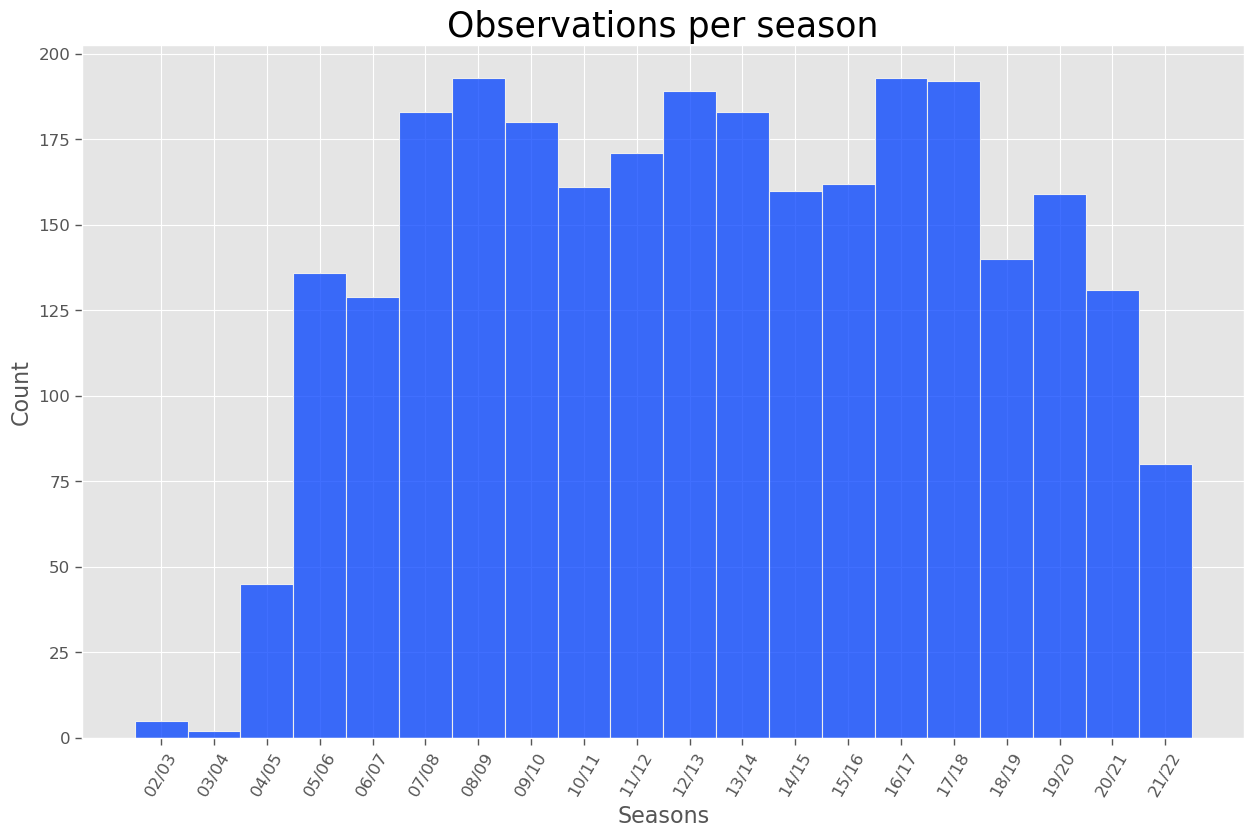

In [423]:
#How many observations remain per season after we have cleaned the dataset?

#Sorting the dataframe by seasons
sorteret = Final_data.sort_values('Season', ascending = True)
#Setting default style
sns.set_style()

fig, ax = plt.subplots(figsize = (15, 9))
ax = sns.histplot(sorteret['Season'], palette = 'deep')

# Choose title for plot and changing font size
ax.set_title('Observations per season') 
ax.title.set_fontsize(25) 

# Choose title for x-axis and changing font size
ax.set_xlabel('Seasons') 
ax.xaxis.label.set_fontsize(16) 

# Choose title y-axis and seeting font size
ax.set_ylabel('Count') 
ax.yaxis.label.set_fontsize(16) 

#Manipulating tick size and direction
rot = plt.xticks(rotation=60)
xsize = plt.xticks(fontsize=12)
ysize = plt.yticks(fontsize=12)

#Saving on computer
plt.savefig('Observations per season.png')

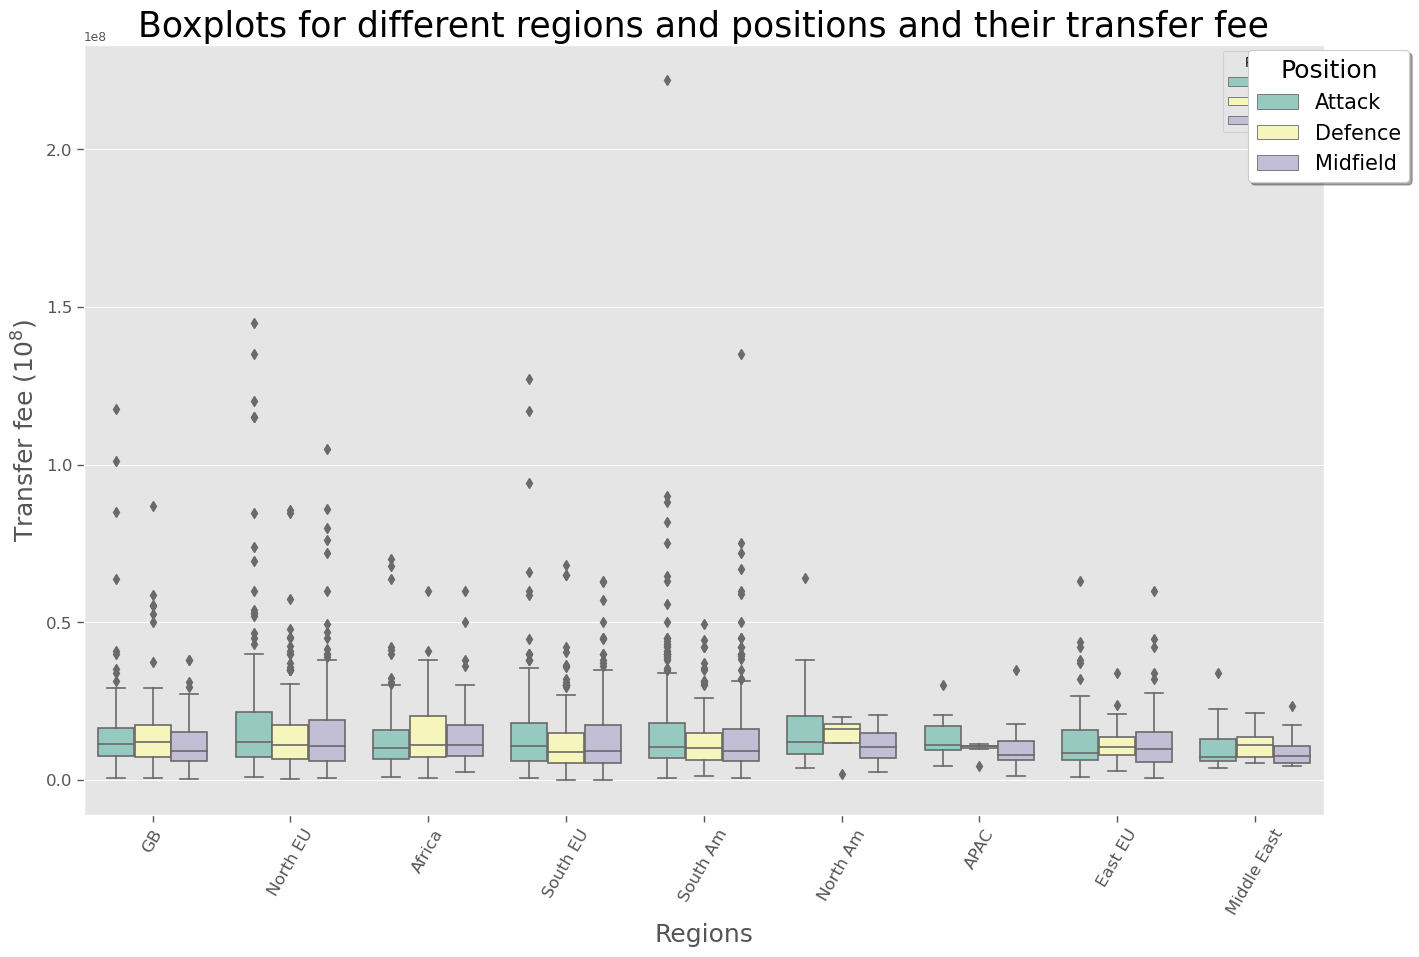

In [424]:
#Overview of transfer prices for different regions and positions
f2, ax2 = plt.subplots(figsize = (16, 10))
sns.boxplot(data = Final_data, x='Nationality', y='Price', hue='Position', palette = 'Set3')

sns.set_context('paper')


# Choose title for plot and changing font size
ax2.set_title('Boxplots for different regions and positions and their transfer fee') 
ax2.title.set_fontsize(25) 

# Choose title for x-axis and changing font size
ax2.set_xlabel('Regions') 
ax2.xaxis.label.set_fontsize(18) 

# Choose title y-axis and seeting font size
ax2.set_ylabel('Transfer fee ($10^8$)') 
ax2.yaxis.label.set_fontsize(18) 

#Manipulating tick size and direction
rot = plt.xticks(rotation=60)
xsize = plt.xticks(fontsize=12)
ysize = plt.yticks(fontsize=12)

#Manipulating legends:
f2.legend(fontsize = 15, \
               bbox_to_anchor= (0.96, 0.885), \
               title="Position", \
               title_fontsize = 18, \
               shadow = True, \
               facecolor = 'white');

#Saving on computer
plt.savefig('Regions, positions and transfer fee.png')

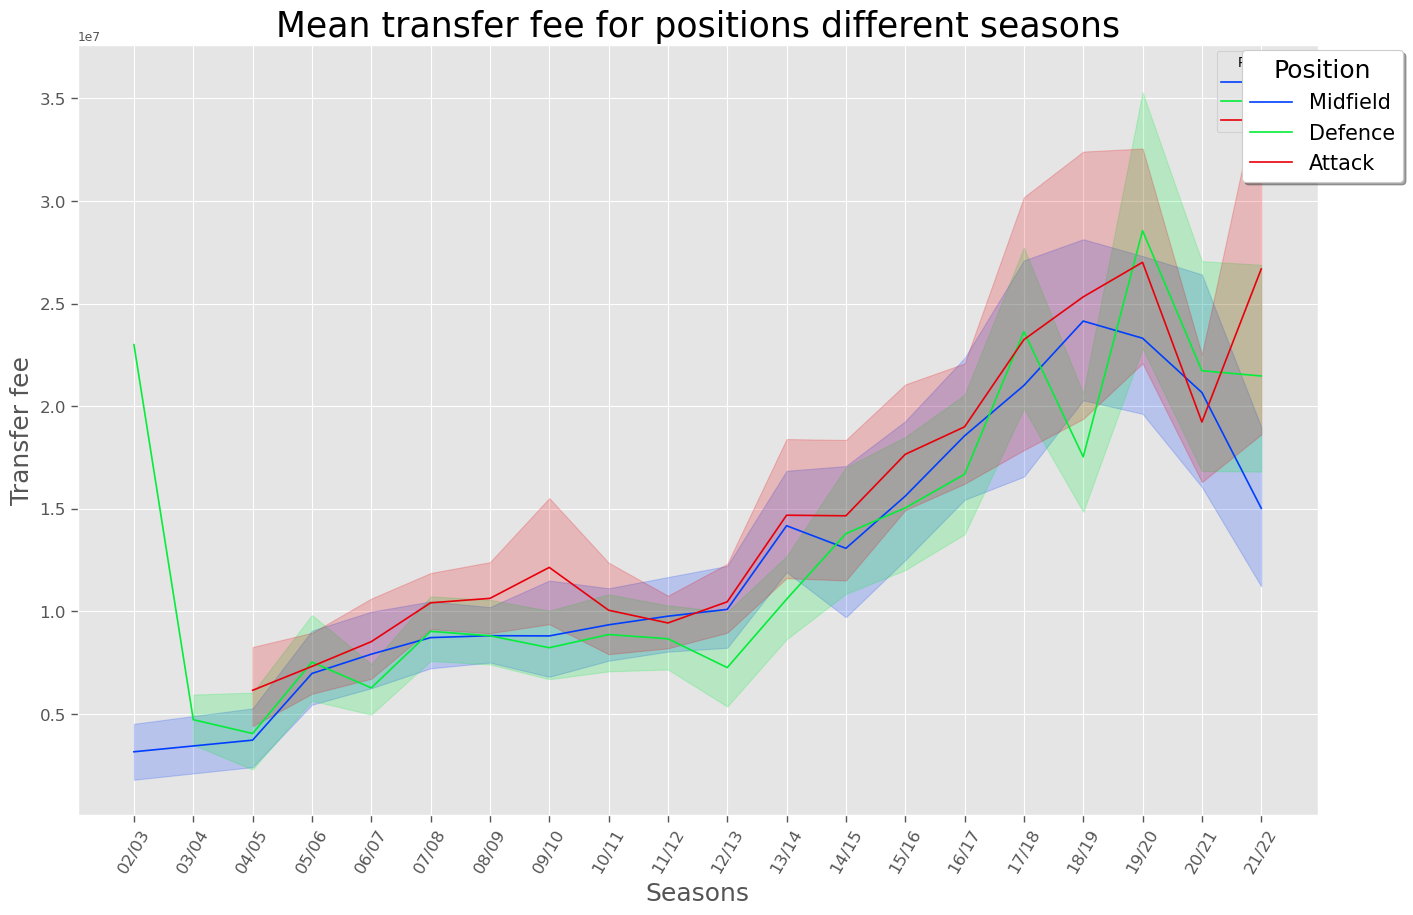

In [425]:
#Lineplot:
f3, ax3 = plt.subplots(figsize = (16, 10))
sns.lineplot(data=sorteret, x="Season", y="Price", hue="Position")


# Choose title for plot and changing font size
ax3.set_title('Mean transfer fee for positions different seasons') 
ax3.title.set_fontsize(25) 

# Choose title for x-axis and changing font size
ax3.set_xlabel('Seasons') 
ax3.xaxis.label.set_fontsize(18) 

# Choose title y-axis and seeting font size
ax3.set_ylabel('Transfer fee') 
ax3.yaxis.label.set_fontsize(18) 

#Manipulating legends:
f3.legend(fontsize = 15, \
               bbox_to_anchor= (0.96, 0.885), \
               title="Position", \
               title_fontsize = 18, \
               shadow = True, \
               facecolor = 'white');

#Manipulating tick size and direction
rot = plt.xticks(rotation=60)
xsize = plt.xticks(fontsize=12)
ysize = plt.yticks(fontsize=12)

#Saving on computer
plt.savefig('Mean transfer fee for positions different seasons.png')

In [426]:
Final_data

,Name,Age,Position,Nationality,Market Value,Left,League left,Joined,Joined League,Price,Season,Matches_played,Goals,Assist,Yellow_cards,Yellow_to_red,Red_cards,Minutes_played
0,Jack Grealish,25,Attack,GB,65000000,Aston Villa,"Top Leagues, left",Man City,"Top Leagues, joined",117500000,21/22,27,7,12,5,0,0,2275
1,Romelu Lukaku,28,Attack,North EU,100000000,Inter,"Top Leagues, left",Chelsea,"Top Leagues, joined",115000000,21/22,44,30,10,7,0,0,3565
2,Jadon Sancho,21,Attack,GB,100000000,Bor. Dortmund,"Top Leagues, left",Man Utd,"Top Leagues, joined",85000000,21/22,38,16,20,1,0,0,2974
3,Raphaël Varane,28,Defence,North EU,70000000,Real Madrid,"Top Leagues, left",Man Utd,"Top Leagues, joined",40000000,21/22,41,2,0,4,0,0,3571
4,Achraf Hakimi,22,Defence,Africa,60000000,Inter,"Top Leagues, left",Paris SG,"Top Leagues, joined",60000000,21/22,45,7,11,9,0,0,3211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,Fabio Cannavaro,28,Defence,South EU,6500000,AC Parma,"Top Leagues, left",Inter,"Top Leagues, joined",23000000,02/03,45,1,0,11,1,1,3983
2790,Stephen Appiah,21,Midfield,Africa,1000000,AC Parma,"Top Leagues, left",Brescia,"Top Leagues, joined",4550000,02/03,23,0,0,2,0,0,1038
2791,Nick Barmby,28,Midfield,GB,600000,Liverpool,"Top Leagues, left",Leeds,"Top Leagues, joined",4500000,02/03,12,0,0,1,0,0,629
2792,Andrés Fleurquín,27,Midfield,South Am,100000,Sturm Graz,"Top Leagues, left",Stade Rennais,"Top Leagues, joined",2000000,02/03,36,3,2,11,0,0,2149


Text(0.5, 0.98, 'Mean for price and market value based on different seasons')

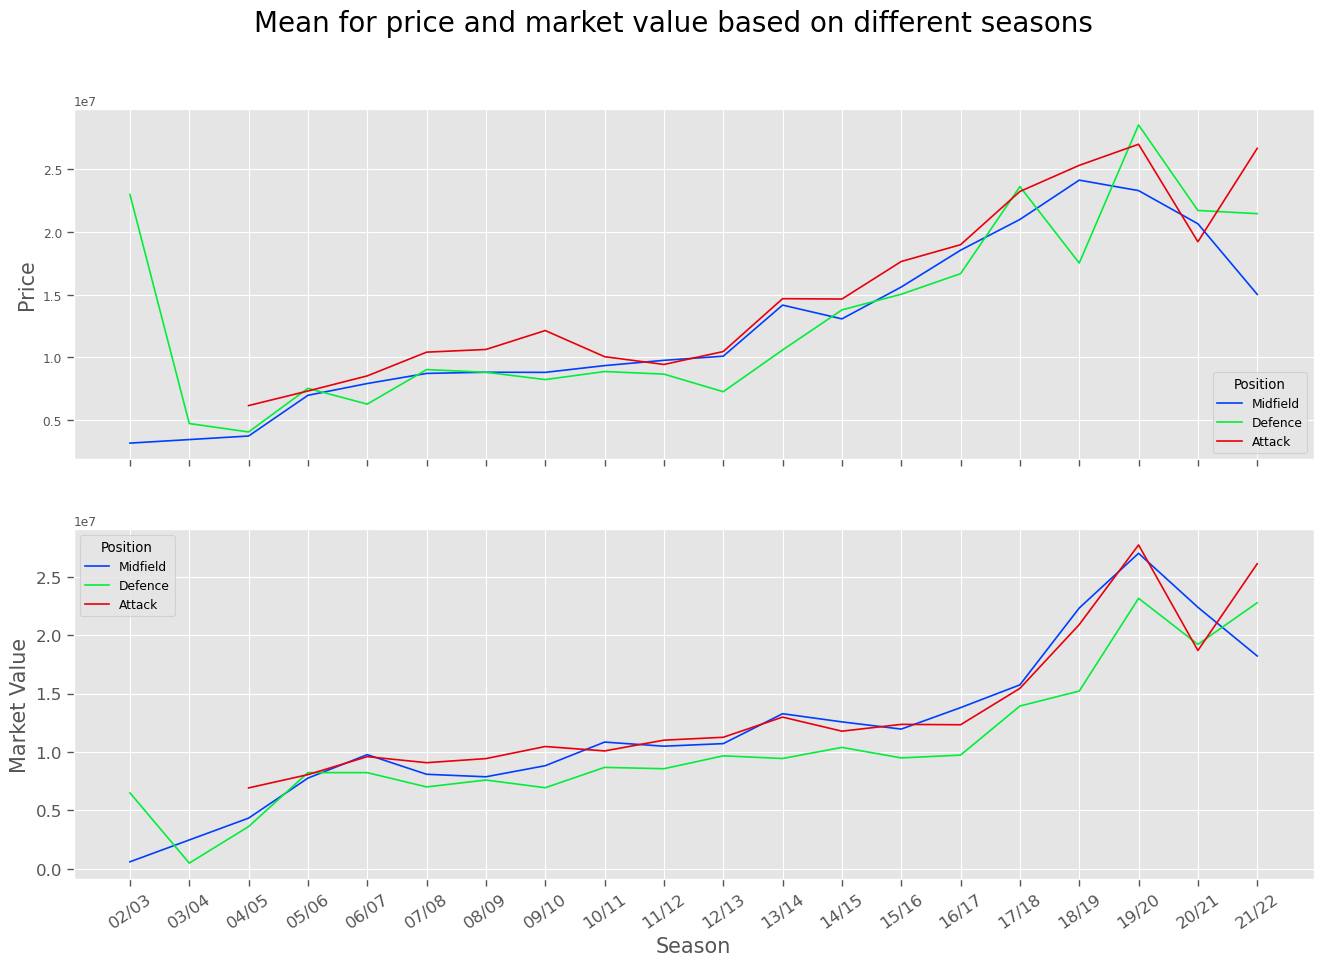

In [427]:
f2, ax2 = plt.subplots(2,1,sharex=True,figsize = (16, 10))
sns.lineplot(data=sorteret, x='Season', y='Price', ci = None ,hue = 'Position',ax=ax2[0])
sns.lineplot(data=sorteret, x='Season', y='Market Value', ci = None,hue = 'Position', ax=ax2[1])

rot = plt.xticks(rotation=35)
xsize = plt.xticks(fontsize=12)
ysize = plt.yticks(fontsize=12)

ax2[0].yaxis.label.set_fontsize(15)
ax2[1].yaxis.label.set_fontsize(15)
ax2[1].xaxis.label.set_fontsize(15)

f2.suptitle('Mean for price and market value based on different seasons', size=(20))


In [428]:
features = pd.get_dummies(Final_data, columns = ['League left','Joined League','Position'])

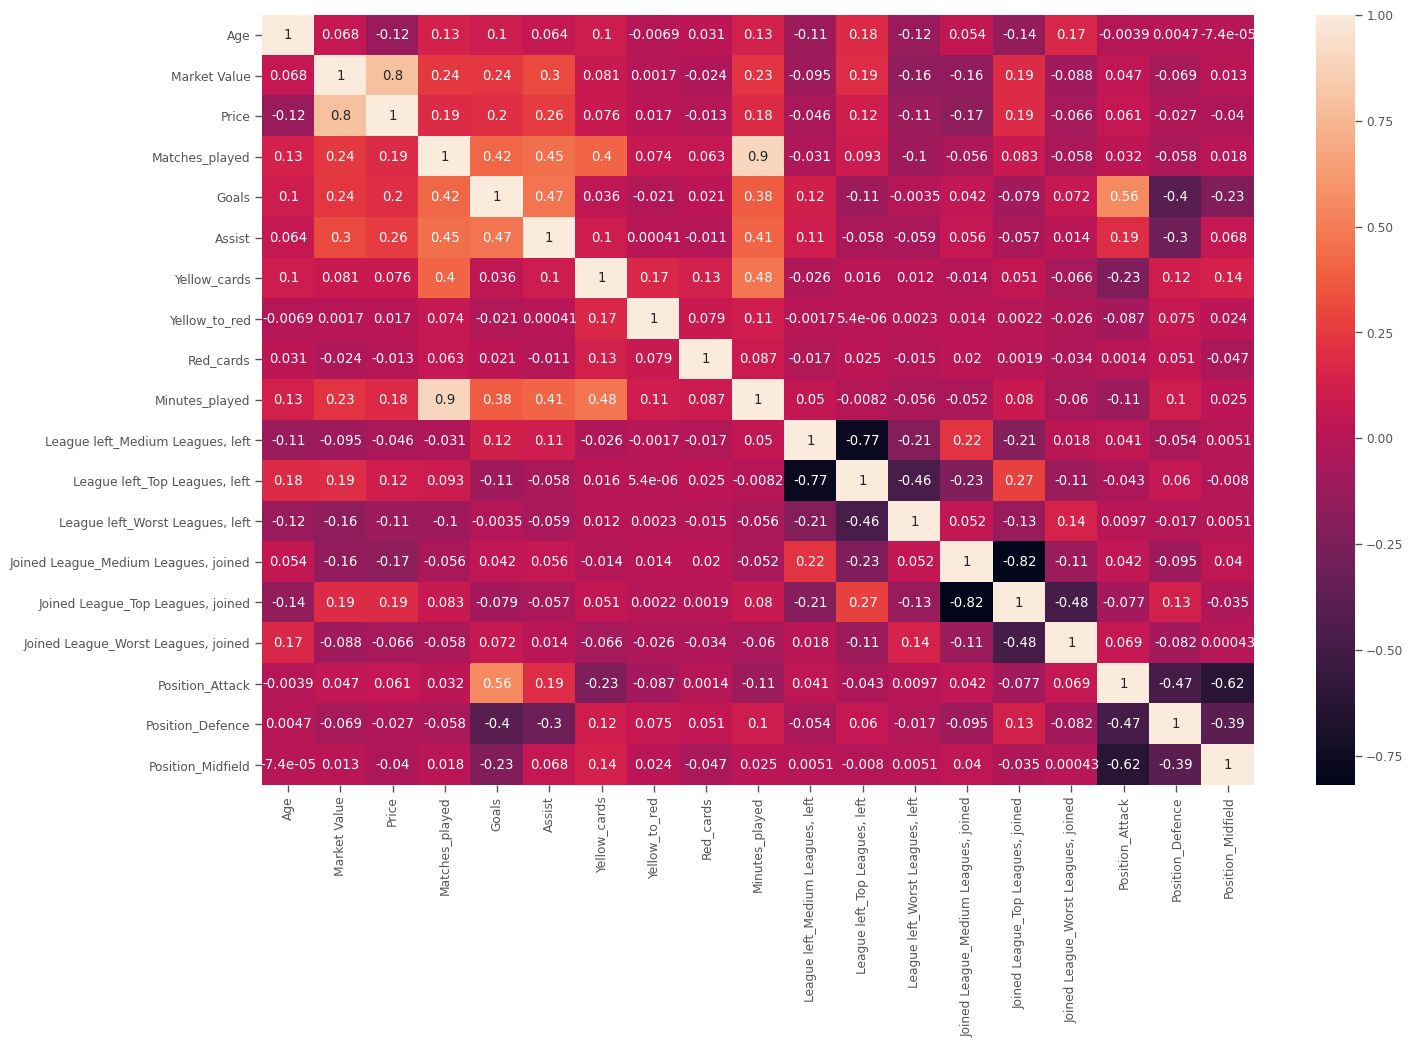

In [429]:
corrMatrix = features.corr()

f3, ax3 = plt.subplots(figsize = (16, 10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Machine Learning - Random Forrest 

In [430]:
#To use these data in our model we have to take the season into account.
#We think the season that a player transfers might affect the price. To take this into account
#We've found a website which shows the european football market value from 2006/2007 till 2018/2019
#From here we've put the numbers into excel and let excel use the data to estimate more data going on to 2002/2003 and 2021/2022
#This might be a bad idea.
#Then we've used the data and found the yearly growth. This will be scalars we add to the players transfer fee.
Final_data['Price'] = scaler(Final_data['Season'], Final_data['Price'])
Final_data['Market Value'] = scaler(Final_data['Season'], Final_data['Market Value'])
Final_data=Final_data.sort_values('Season', ascending = True)#.drop('Season',axis = 1)

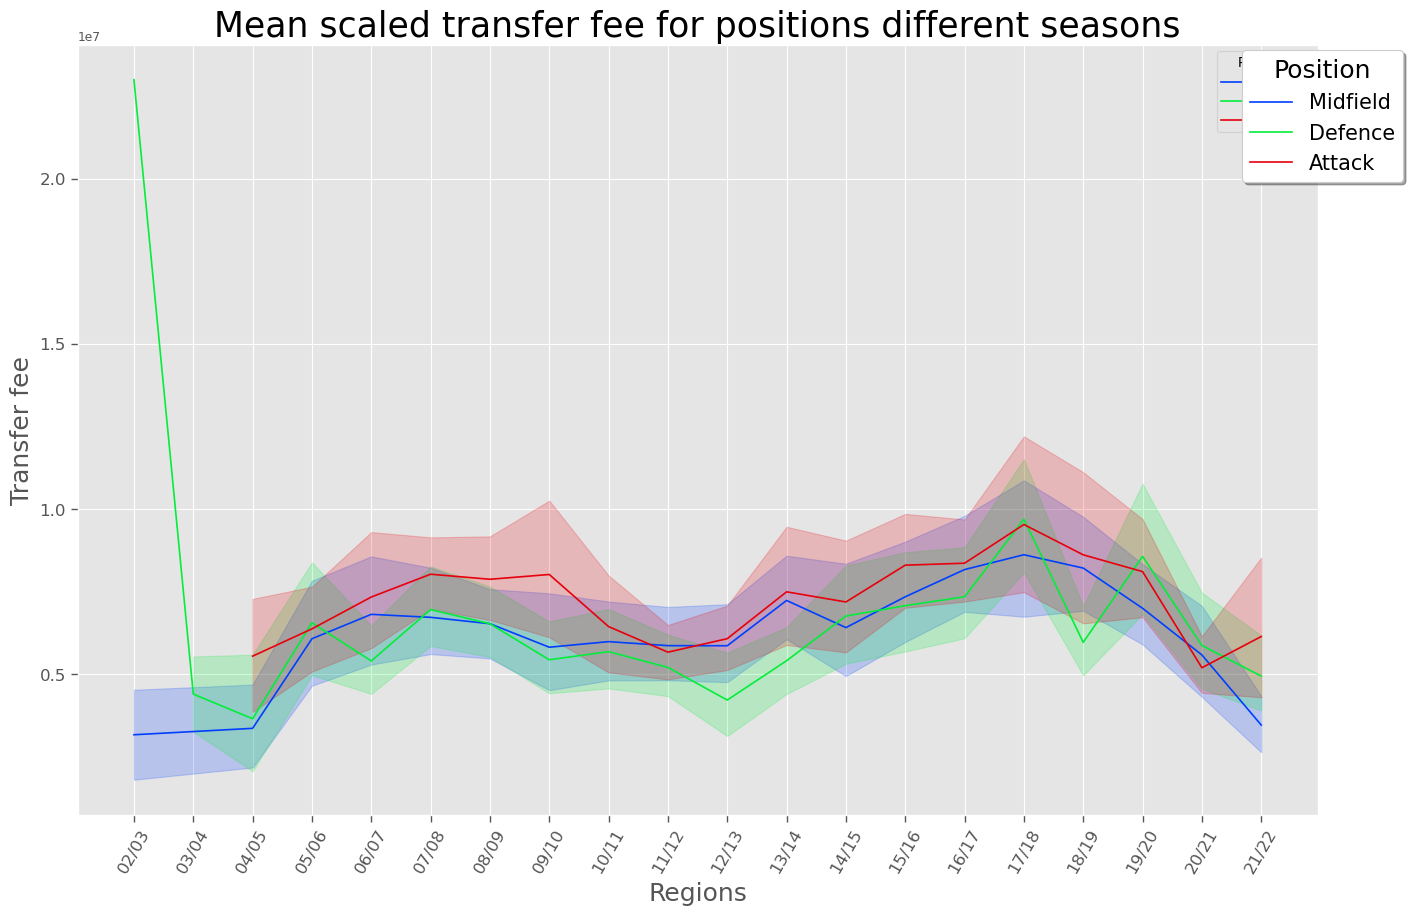

In [431]:
#Lineplot:
f3, ax3 = plt.subplots(figsize = (16, 10))
sns.lineplot(data=Final_data, x="Season", y="Price", hue="Position")


# Choose title for plot and changing font size
ax3.set_title('Mean scaled transfer fee for positions different seasons') 
ax3.title.set_fontsize(25) 

# Choose title for x-axis and changing font size
ax3.set_xlabel('Regions') 
ax3.xaxis.label.set_fontsize(18) 

# Choose title y-axis and seeting font size
ax3.set_ylabel('Transfer fee') 
ax3.yaxis.label.set_fontsize(18) 


#Manipulating legends:
f3.legend(fontsize = 15, \
               bbox_to_anchor= (0.96, 0.885), \
               title="Position", \
               title_fontsize = 18, \
               shadow = True, \
               facecolor = 'white');

#Manipulating tick size and direction
rot = plt.xticks(rotation=60)
xsize = plt.xticks(fontsize=12)
ysize = plt.yticks(fontsize=12)

#Saving on computer
plt.savefig('Mean scaled transfer fee for positions different seasons.png')

In [432]:
Final_data = Final_data.drop('Season',axis=1)

Best accuracy:  45.191392757891144
Index number for best accuracy:  625


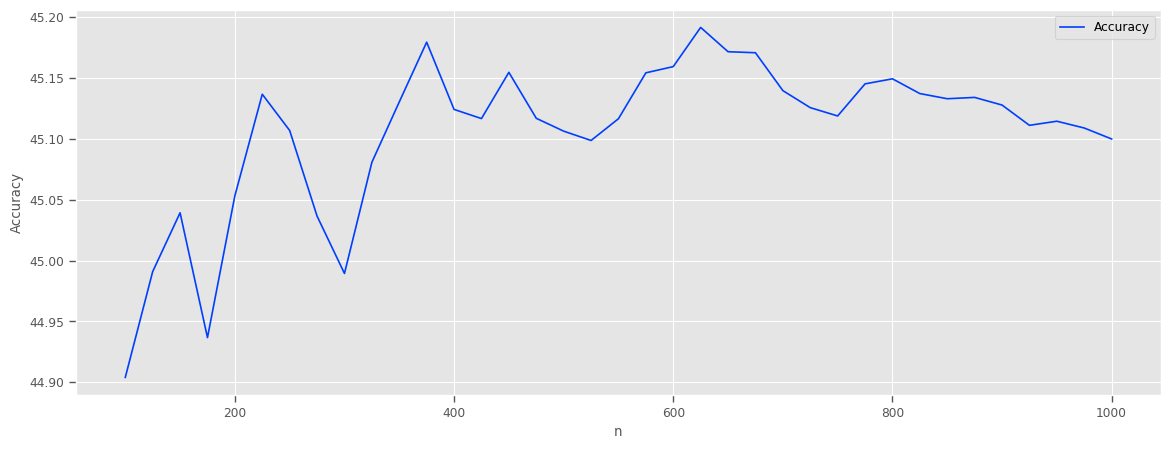

In [433]:
X_train, X_test, y_train, y_test, best_n = best_mse(Final_data)

In [434]:
predictions, importances, feature_list = forrest(Final_data, best_n ,X_train, X_test, y_train, y_test)


Training features Shape: (1871, 27)
Training targets Shape: (1871,)
Testing features Shape: (923, 27)
Testing targets Shape: (923,)
Mean Absolute Error: 2293181.06 fee.
Accuracy:  45.191392757891144
Variable: Market Value         Importance: 0.6762
Variable: Age                  Importance: 0.0731
Variable: Minutes_played       Importance: 0.0445
Variable: Assist               Importance: 0.0416
Variable: Matches_played       Importance: 0.0363
Variable: Goals                Importance: 0.0324
Variable: Yellow_cards         Importance: 0.0291
Variable: Yellow_to_red        Importance: 0.0064
Variable: Nationality_South Am Importance: 0.0057
Variable: Nationality_South EU Importance: 0.0052
Variable: Position_Midfield    Importance: 0.0052
Variable: Nationality_GB       Importance: 0.0051
Variable: Nationality_North EU Importance: 0.0051
Variable: Red_cards            Importance: 0.0049
Variable: League left_Medium Leagues, left Importance: 0.0038
Variable: League left_Top Leagues, left

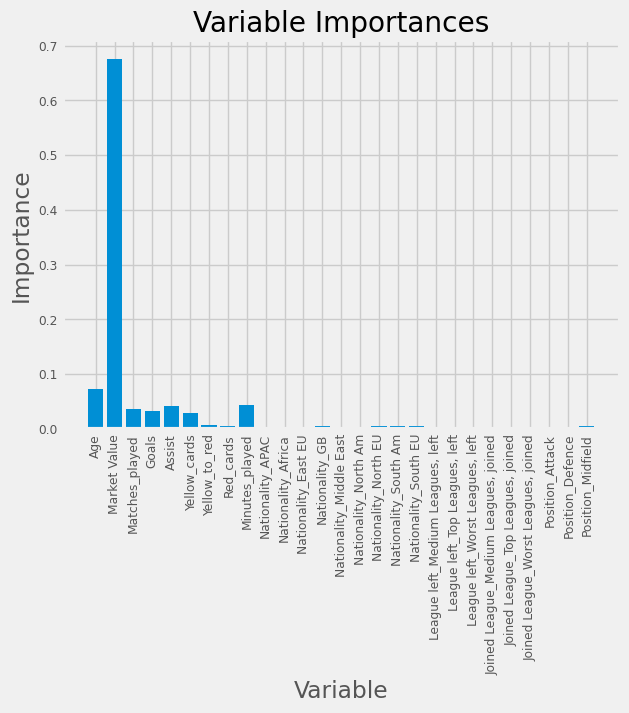

In [435]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

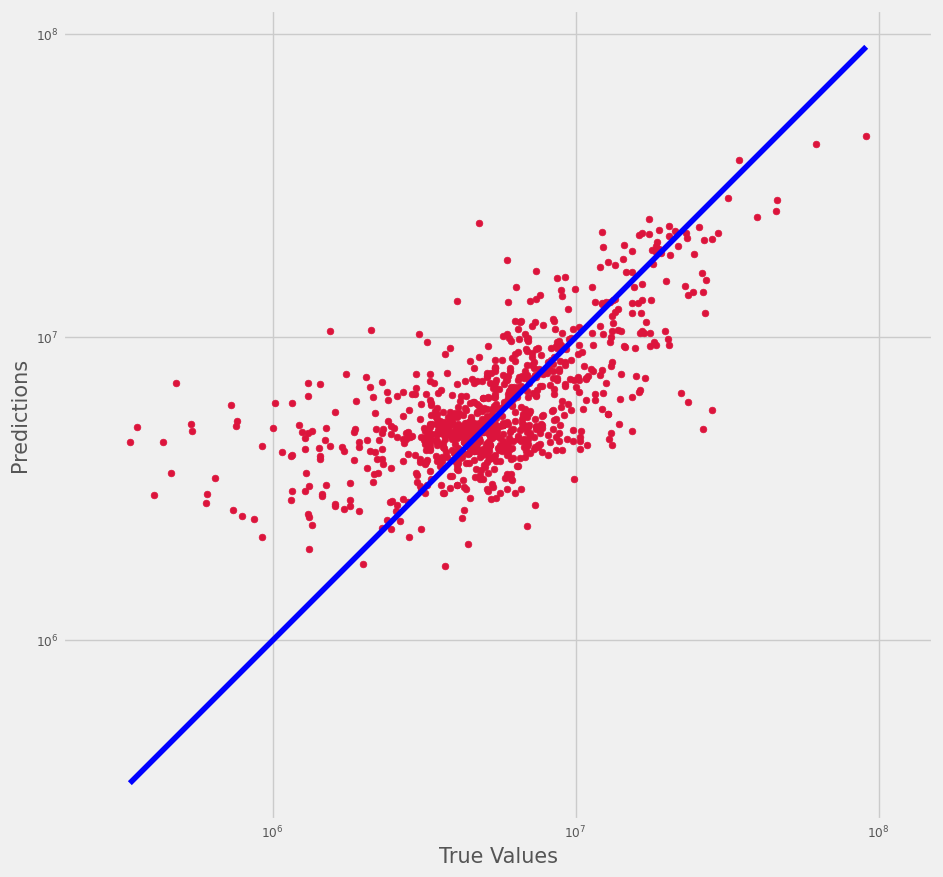

In [436]:
#Lets make a plot to see the difference between the true and predicted values.
plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, c ='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [437]:
#We notice, that we have a few observations that confuse our model. 
#These observations are transfer feees below 1.000.000€ in 2002/2003 scales.
#Cutting of players that seem to confuse the model
obs = Final_data.Price > 1000000
Final_data = Final_data[obs].reset_index(drop = True)

# getting the dummies
features = pd.get_dummies(Final_data, columns = ['Nationality','League left','Joined League','Position']).drop(columns= ['Name','Left','Joined'])

# Labels are the values we want to predict
y = np.array(features['Price'])
# Remove the labels from the features
# axis 1 refers to the columns
X = features.drop(['Price'], axis = 1)
# Convert to numpy array
X = np.array(X)
    
features = features.drop('Price',axis=1)
feature_list = list(features.columns)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)


#We look at the shape of all the data to make sure we did everything correctly. 
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = best_n, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'fee.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy: ', accuracy)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Mean Absolute Error: 2380996.93 fee.
Accuracy:  55.90025740545719
Variable: Market Value         Importance: 0.663
Variable: Age                  Importance: 0.0689
Variable: Minutes_played       Importance: 0.0518
Variable: Assist               Importance: 0.0418
Variable: Goals                Importance: 0.0359
Variable: Matches_played       Importance: 0.0358
Variable: Yellow_cards         Importance: 0.031
Variable: Nationality_GB       Importance: 0.0085
Variable: Nationality_North EU Importance: 0.0064
Variable: Yellow_to_red        Importance: 0.0058
Variable: Nationality_South Am Importance: 0.0055
Variable: Red_cards            Importance: 0.005
Variable: Nationality_South EU Importance: 0.0049
Variable: Position_Midfield    Importance: 0.0046
Variable: League left_Medium Leagues, left Importance: 0.0043
Variable: Position_Attack      Importance: 0.0039
Variable: League left_Top Leagues, left Importance: 0.0037
Variable: Position_Defence     Importance: 0.0036
Variable: Nation

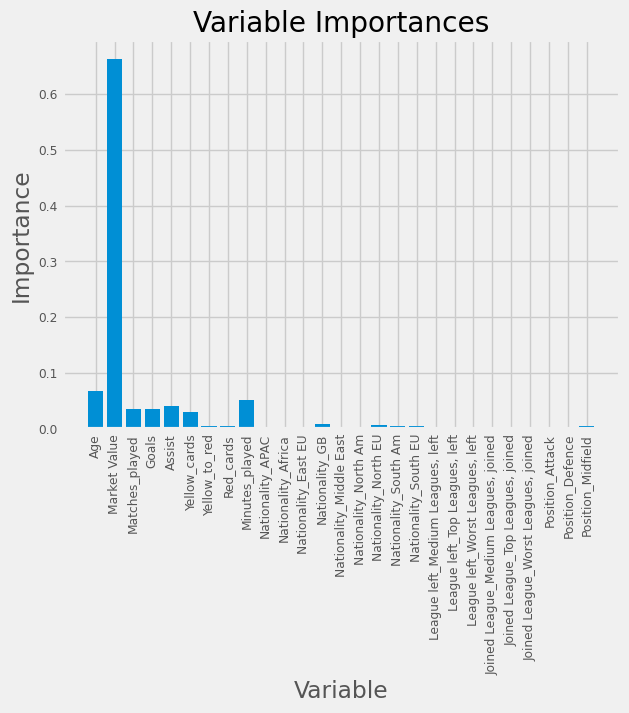

In [438]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [439]:
# getting the dummies
features = pd.get_dummies(Final_data, columns = ['Nationality','League left','Joined League','Position']).drop(columns= ['Name','Left','Joined'])

# Labels are the values we want to predict
y = np.array(features['Market Value'])
# Remove the labels from the features
# axis 1 refers to the columns
X = features.drop(['Market Value','Price'], axis = 1)
# Convert to numpy array
X = np.array(X)
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

#ignorer denne celle
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'fee.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 4), '%.')
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Mean Absolute Error: 2989751.19 fee.
Accuracy: -2.1562 %.
Variable: Goals                Importance: 0.1637
Variable: Matches_played       Importance: 0.1518
Variable: Red_cards            Importance: 0.1409
Variable: Market Value         Importance: 0.1158
Variable: Age                  Importance: 0.0941
Variable: Assist               Importance: 0.0751
Variable: League left_Medium Leagues, left Importance: 0.0717
Variable: Joined League_Medium Leagues, joined Importance: 0.0231
Variable: Yellow_cards         Importance: 0.0195
Variable: Nationality_North Am Importance: 0.0182
Variable: Nationality_North EU Importance: 0.0179
Variable: Nationality_South Am Importance: 0.0155
Variable: Yellow_to_red        Importance: 0.0123
Variable: Position_Defence     Importance: 0.0119
Variable: Nationality_East EU  Importance: 0.011
Variable: Nationality_Africa   Importance: 0.009
Variable: Joined League_Worst Leagues, joined Importance: 0.0087
Variable: Nationality_South EU Importance: 0.0086
V

In [440]:
#We see that the model isnt particularly accurate at predicting the market value.

## Machine Learning - Linear regression 

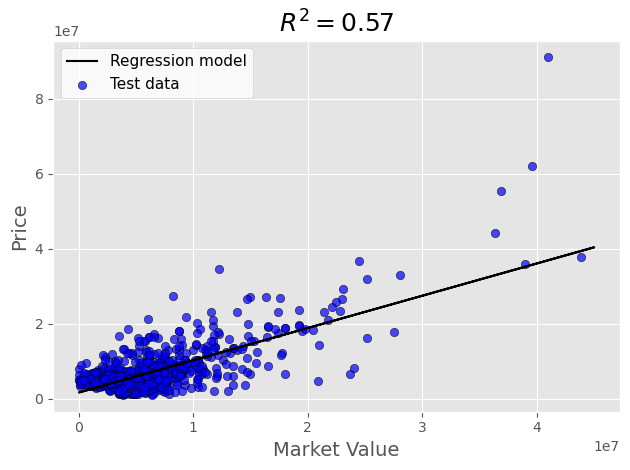

In [441]:
#as we have seen. Our most important feature is the market value, and now we want to make OLS
#between transfer fee and market value.
# getting the dummies
features = pd.get_dummies(Final_data, columns = ['Nationality','League left','Joined League','Position']).drop(columns= ['Name','Left','Joined'])

# Labels are the values we want to predict
y = np.array(features['Price'])
# Remove the labels from the features
# axis 1 refers to the columns
X = features['Market Value'].values.reshape(-1,1)#.drop(['Price'], axis = 1)
# Convert to numpy array
X = np.array(X)
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

################################################ Train #############################################

ols = linear_model.LinearRegression().fit(X_train, y_train)
response = ols.predict(X_train)

############################################## Evaluate ############################################

r_sq = ols.score(X_test, y_test)

############################################## Plot ################################################

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots()

ax.plot(X_train, response, color='k', label='Regression model')
ax.scatter(X_test, y_test, edgecolor='k', facecolor='blue', alpha=0.7, label='Test data')
ax.set_ylabel('Price', fontsize=14)
ax.set_xlabel('Market Value', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.2f$' % r_sq, fontsize=18)

fig.tight_layout()